In [33]:
import pandas as pd

In [34]:
csv_path = '/Users/Jiwon/Documents/GitHub/advanced_project/jiwon_project/1.preprocessing/entire_remove_outlier.csv'    # 여기에 absolute path
# CSV 읽기
df = pd.read_csv(
    csv_path,
    header=0,        # 첫 줄을 컬럼명으로 사용,  # 인덱스 컬럼으로 id 지정
    encoding='utf-8-sig'
)

In [69]:
import ast

# 1) host_verifications 리스트 문자열 → 실제 파이썬 리스트로 변환
def parse_verifications(x):
    try:
        # 문자열 "[...]" → list([...])
        lst = ast.literal_eval(x)
        return lst if isinstance(lst, list) else []
    except:
        return []

df['host_verifications_list'] = df['host_verifications'].apply(parse_verifications)

# 2) 리스트 길이(검증 개수)를 숫자로 저장
df['host_verifications_count'] = df['host_verifications_list'].apply(len)

/var/folders/6n/tjcbrygj54s39y61m4r7ymrr0000gq/T/ipykernel_90984/1821460171.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['host_verifications_list'] = df['host_verifications'].apply(parse_verifications)
/var/folders/6n/tjcbrygj54s39y61m4r7ymrr0000gq/T/ipykernel_90984/1821460171.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['host_verifications_count'] = df['host_verifications_list'].apply(len)


# 인프라 관광 교통 정보 넣기


In [35]:
import time
import json
import pandas as pd
import requests

import geopandas as gpd
from shapely.geometry import Point

# ─────────────────────────────────────────────────────────────────────────────
# 0) 원본 df, poi_tags, 그리고 bbox 계산
  # latitude, longitude 칼럼이 있어야 함

poi_tags = {
    'transport': {
        'amenity': ['bus_station','taxi'],
        'railway': ['station']
    },
    'infrastructure': {
        'amenity': ['police','hospital','pharmacy','restaurant','supermarket']
    },
    'tourism': {
        'tourism': ['viewpoint','museum','attraction'],
        'leisure': ['park']
    }
}

pad = 0.01
minx, maxx = df.longitude.min()-pad, df.longitude.max()+pad
miny, maxy = df.latitude.min()-pad, df.latitude.max()+pad

# ─────────────────────────────────────────────────────────────────────────────
# 1) 한 번에 bbox 내 모든 POI 내려받기 (Overpass bbox 쿼리)
OVERPASS_URL = "http://overpass-api.de/api/interpreter"
# build filters for bbox query
filters = ""
for grp in poi_tags.values():
    for key, vals in grp.items():
        for v in vals:
            filters += f'node["{key}"="{v}"]({miny},{minx},{maxy},{maxx});\n'

# full query
query = f"""
[out:json][timeout:180];
(
{filters}
);
out body;
"""

resp = requests.post(OVERPASS_URL, data={'data': query}, timeout=(5,300))
resp.raise_for_status()
data = resp.json().get('elements', [])

# ─────────────────────────────────────────────────────────────────────────────
# 2) GeoDataFrame 생성
pois = pd.DataFrame([
    {
      'lon': el['lon'],
      'lat': el['lat'],
      **el.get('tags',{})
    }
    for el in data
    if el['type']=='node' and 'lon' in el
])
gdf_pois = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(pois.lon, pois.lat),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# 원본 좌표도 GeoDataFrame
gdf_pts = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
).to_crs(epsg=3857)

sindex = gdf_pois.sindex

# ─────────────────────────────────────────────────────────────────────────────
# 3) 그룹별 카운트 함수
def count_group(pt, grp_map, radius=1000):
    buf = pt.buffer(radius)
    candidates = gdf_pois.iloc[list(sindex.intersection(buf.bounds))]
    cnt = 0
    for key, vals in grp_map.items():
        cnt += candidates[candidates[key].isin(vals)].shape[0]
    return cnt

# 4) 각 포인트별 count, df에 붙이기
for grp, tags in poi_tags.items():
    df[f"{grp}_count"] = [
        count_group(pt, tags, radius=1000)
        for pt in gdf_pts.geometry
    ]

# 5) 결과 확인
print(df[['transport_count','infrastructure_count','tourism_count']].head())


   transport_count  infrastructure_count  tourism_count
0                7                    78              1
1                3                    79              4
2                4                    34              2
3                7                   117              1
4               15                   335              3


In [36]:
df

,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,structure_encoded,log_price,room_new_type,transport_count,infrastructure_count,tourism_count
0,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,62165,Michael,2009,"New York, NY",I’m an urban planner working for an internatio...,NaN,...,False,False,True,False,23,5.303305,mid,7,78,1
1,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",157798,Irene,2010,"New York, NY",NaN,NaN,...,False,False,True,False,8,4.418841,upper-mid,3,79,4
2,city scrape,Spectacular West Harlem Garden Apt,This is a very large and unique space. An inc...,West Harlem is now packed with great restauran...,166532,Matthew,2010,"New York, NY",I have been a New Yorker for a long time\n and...,within an hour,...,True,False,False,False,14,4.941642,low-mid,4,34,2
3,city scrape,“Work-from-home” from OUR home.,*Monthly Discount will automatically apply <br...,THE NEIGHBORHOOD:<br />Our apartment is locate...,168525,Gustavo,2010,"New York, NY",I am a music producer. And my wife is a hair s...,within an hour,...,False,False,True,False,23,4.875197,mid,7,117,1
4,city scrape,1 br in a 2 br apt (Midtown West),NaN,NaN,169927,Hubert,2010,"Saint-Aubin-sur-Scie, France","Facebook Likes:\r\nNew York French Geek, David...",NaN,...,False,False,True,False,23,4.941642,mid,15,335,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20555,city scrape,Beautiful 1-Bed Apt in Harlem!,Welcome to your temporary home in the vibrant ...,NaN,40019013,Cecilia,2015,"New York, NY",NaN,NaN,...,False,False,True,False,23,4.290459,mid,4,58,4
20556,city scrape,Private Room w/ Ensuite Bath H,Stylish Private Rooms w/ En-Suite Baths in Bro...,NaN,483056418,Kristina,2022,"New York, NY",Are you tired of the tedious and time-consumin...,within an hour,...,False,False,True,False,23,4.077537,mid,4,27,1
20557,city scrape,2 Bedroom on East Side,Located in the Murray Hill area and occupies a...,NaN,30283594,Global Luxury Suites,2015,"Hawthorne, NJ",NaN,within an hour,...,True,False,False,False,23,5.703782,mid,8,276,6
20558,city scrape,Stylish 2Bd near Bryant Park,Enjoy everything the city has to offer while l...,NaN,407304997,Boomerang,2021,"New York, NY","At Boomerang, we believe in the idea ""you get ...",within an hour,...,True,False,False,False,23,5.303305,mid,19,340,9


# "estimated_occupancy_l365d"

In [37]:
# 위데이터 넣어서 구하기

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# 1) 데이터 불러오기 & 피처/타깃 설정
TARGET = "estimated_occupancy_l365d"
features = [  # 앞서 선정한 피처 리스트
 'log_price',
 'instant_bookable',
 'availability_90',
 'host_listings_count',
 'is_long_term',
 'is_activate',
 'amenities_cnt',
 'accommodates',
 'bath_score_mul',
 'number_of_reviews',
 'review_scores_rating',
 'name_length_group',
 'description_length_group',
 'neighborhood_overview_exists',
 'host_about_length_group',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_response_rate_score',
 'host_acceptance_rate_score',
 'host_location_ny',
 'host_location_boolean',
 'town_encoded',
 'structure_encoded',
 'transport_count','infrastructure_count','tourism_count']
X = df[features].fillna(0)
y = df[TARGET]

# 2) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) 하이퍼파라미터 분포 설정
rf = RandomForestRegressor(random_state=42)
rf_params = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_params = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# 4) RandomizedSearchCV
rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

xgb_search = RandomizedSearchCV(
    xgb, xgb_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

print("✔ Best RF params:", rf_search.best_params_)
print("✔ Best XGB params:", xgb_search.best_params_)

# 5) 검증 성능 (튜닝 후)
def eval_model(model, X_t, y_t):
    y_pred = model.predict(X_t)
    return root_mean_squared_error(y_t, y_pred), mean_absolute_error(y_t, y_pred), r2_score(y_t, y_pred)

rf_rmse, rf_mae, rf_r2 = eval_model(best_rf, X_test, y_test)
xgb_rmse, xgb_mae, xgb_r2 = eval_model(best_xgb, X_test, y_test)
print(f"RF tuned  RMSE={rf_rmse:.2f}, MAE={rf_mae:.2f}, R2 Score={rf_r2:.2f}")
print(f"XGB tuned RMSE={xgb_rmse:.2f}, MAE={xgb_mae:.2f}, R2 Score={xgb_r2:.2f}")

# 6) Ensemble: Voting Regressor
voting = VotingRegressor([("rf", best_rf), ("xgb", best_xgb)])
voting.fit(X_train, y_train)
v_rmse, v_mae, v_r2 = eval_model(voting, X_test, y_test)
print(f"Voting   RMSE={v_rmse:.2f}, MAE={v_mae:.2f}, R2 Score={v_r2:.2f}")

# 7) Ensemble: Stacking Regressor
stack = StackingRegressor(
    estimators=[("rf", best_rf), ("xgb", best_xgb)],
    final_estimator=RidgeCV(),
    cv=3,
    n_jobs=-1
)
stack.fit(X_train, y_train)
s_rmse, s_mae, s_r2 = eval_model(stack, X_test, y_test)
print(f"Stacking RMSE={s_rmse:.2f}, MAE={s_mae:.2f}, R2 Score={s_r2:.2f}")

print(rf_r2, xgb_r2, v_r2, s_r2)


✔ Best RF params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
✔ Best XGB params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
RF tuned  RMSE=47.52, MAE=27.96, R2 Score=0.76
XGB tuned RMSE=48.22, MAE=29.64, R2 Score=0.76
Voting   RMSE=47.45, MAE=28.60, R2 Score=0.76
Stacking RMSE=47.37, MAE=28.41, R2 Score=0.76
0.7622214564636092 0.7551865577697754 0.7629192129410981 0.763767642993121


=== Feature Importances ===
number_of_reviews               0.380582
is_long_term                    0.182244
host_is_superhost               0.077977
availability_90                 0.071747
is_activate                     0.032463
log_price                       0.032262
host_listings_count             0.029701
infrastructure_count            0.029406
amenities_cnt                   0.026226
review_scores_rating            0.023129
town_encoded                    0.021009
transport_count                 0.015147
tourism_count                   0.012881
host_acceptance_rate_score      0.012612
accommodates                    0.009548
structure_encoded               0.009383
bath_score_mul                  0.006024
host_about_length_group         0.005281
description_length_group        0.004133
neighborhood_overview_exists    0.004032
name_length_group               0.003793
host_location_ny                0.002871
instant_bookable                0.002858
host_location_boolean        

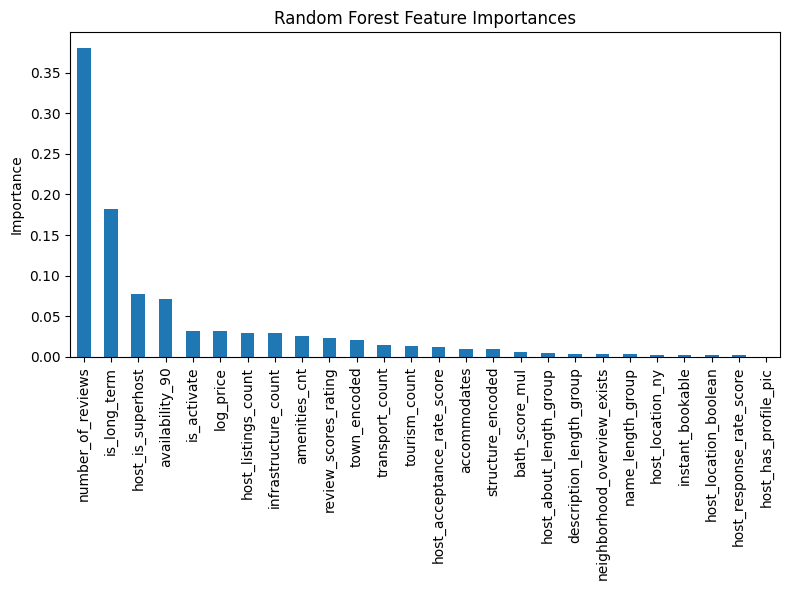


=== Variance Inflation Factors ===
                         feature         VIF
0                          const  361.047483
21         host_location_boolean    3.447259
20              host_location_ny    3.216138
24               transport_count    3.060037
25          infrastructure_count    2.931150
26                 tourism_count    2.596336
1                      log_price    2.052285
4            host_listings_count    1.676004
8                   accommodates    1.565500
5                   is_long_term    1.424215
7                  amenities_cnt    1.397485
2               instant_bookable    1.346505
6                    is_activate    1.326909
9                 bath_score_mul    1.308248
14  neighborhood_overview_exists    1.269456
19    host_acceptance_rate_score    1.260160
15       host_about_length_group    1.258474
16             host_is_superhost    1.236713
10             number_of_reviews    1.209347
18      host_response_rate_score    1.152093
12             name

In [38]:
import pandas as pd
import numpy as np

# 1) 필요한 라이브러리 임포트
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 2) 피처/타깃 정의 (df, TARGET, features 는 이미 정의된 상태라 가정)
# 예시:
# TARGET = "estimated_occupancy_l365d"
# features = base_feats + ['transport_count','infrastructure_count','tourism_count']

X = df[features].fillna(0)
y = df[TARGET]

# 3) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) 랜덤포레스트 모델 학습 (피처임포턴스용)
rf = RandomForestRegressor(
    n_estimators=500, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)

# 5) 피처임포턴스 출력
importances = pd.Series(
    rf.feature_importances_,
    index=features
).sort_values(ascending=False)
print("=== Feature Importances ===")
print(importances)

# (옵션) 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
importances.plot.bar()
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# 6) VIF 계산을 위해 상수항 추가
X_train_sm = sm.add_constant(X_train)

# 7) VIF 계산
vif = pd.DataFrame({
    'feature': X_train_sm.columns,
    'VIF': [
        variance_inflation_factor(X_train_sm.values, i)
        for i in range(X_train_sm.shape[1])
    ]
}).sort_values('VIF', ascending=False)
print("\n=== Variance Inflation Factors ===")
print(vif)


In [39]:
list(df.columns)

['source',
 'name',
 'description',
 'neighborhood_overview',
 'host_id',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'calendar_last_scraped',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'availab

In [40]:
df[['estimated_occupancy_l365d', 'reviews_per_month']].describe()

,estimated_occupancy_l365d,reviews_per_month
count,20560.000000,14656.000000
mean,74.498103,1.170699
std,97.367183,2.268489
min,0.000000,0.010000
25%,0.000000,0.190000
50%,0.000000,0.510000
75%,120.000000,1.500000
max,255.000000,117.980000


In [41]:
df['reserved_days'] = df['reviews_per_month'] * 2 * 12

In [42]:
df[['estimated_occupancy_l365d', 'reserved_days']]

,estimated_occupancy_l365d,reserved_days
0,0,1.20
1,0,13.92
2,255,32.64
3,154,36.96
4,0,6.00
...,...,...
20555,0,NaN
20556,0,NaN
20557,0,NaN
20558,0,NaN


In [43]:
df.loc[df['reserved_days'].isnull()]['estimated_occupancy_l365d'].describe()
# 전부 0이 나옴 => reserved_days 결측치 0으로 채워줌


count    5904.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: estimated_occupancy_l365d, dtype: float64

In [51]:
df['reserved_days'] = df['reserved_days'].fillna(0)

In [59]:
df['reserved_days'] = df['reserved_days'].clip(upper=255)

In [60]:
df['reserved_days'].describe()

count    20560.000000
mean        19.108202
std         32.614040
min          0.000000
25%          0.000000
50%          5.520000
75%         23.760000
max        255.000000
Name: reserved_days, dtype: float64

In [63]:
list(df.columns)

['source',
 'name',
 'description',
 'neighborhood_overview',
 'host_id',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'calendar_last_scraped',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'availab

In [70]:
jiwon_list = [
 'host_is_superhost',
 'host_listings_count',
 'host_verifications_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'accommodates',
 'bedrooms',
 'beds',
 'price',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'number_of_reviews_ly',
 'estimated_occupancy_l365d',
 'review_scores_rating',
 'instant_bookable',
 'calculated_host_listings_count',
 'is_long_term',
 'amenities_cnt',
 'neighborhood_overview_exists',
 'name_length',
 'name_length_group',
 'description_length',
 'description_length_group',
 'host_about_length',
 'host_about_length_group',
 'host_response_time_score',
 'host_response_rate_score',
 'host_acceptance_rate_score',
 'host_location_boolean',
 'host_location_ny',
 'is_shared',
 'is_private',
 'bath_score_mul',
 'room_structure_type',
 'is_activate',
 'town_encoded',
 'neighbourhood_group_cleansed_Bronx',
 'neighbourhood_group_cleansed_Brooklyn',
 'neighbourhood_group_cleansed_Manhattan',
 'neighbourhood_group_cleansed_Queens',
 'neighbourhood_group_cleansed_Staten Island',
 'room_type_Entire home/apt',
 'room_type_Hotel room',
 'room_type_Private room',
 'room_type_Shared room',
 'structure_encoded',
 'log_price',
 'room_new_type',
 'transport_count',
 'infrastructure_count',
 'tourism_count',
 'reserved_days']

In [ ]:
df = df[jiwon_list]

In [72]:
import pandas as pd
import numpy as np
from scipy.stats import (
    shapiro, levene, ttest_ind, mannwhitneyu,
    f_oneway, kruskal, pearsonr, spearmanr
)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

ALPHA = 0.05
N_CAT = 10  # 최대 카테고리 수(이하일 때 범주형으로 처리)

def two_group_test(x, y):
    """2그룹 연속 vs 연속형 대상 검정 (t-test 계열 or Mann-Whitney)"""
    # 정규성 검사
    n1, n2 = shapiro(x).pvalue > ALPHA, shapiro(y).pvalue > ALPHA
    # 등분산성 검사
    ev = levene(x, y).pvalue > ALPHA
    
    if n1 and n2 and ev:
        return "Student’s t‑test", *ttest_ind(x, y, equal_var=True)
    elif n1 and n2 and not ev:
        return "Welch’s t‑test", *ttest_ind(x, y, equal_var=False)
    else:
        return "Mann–Whitney U", *mannwhitneyu(x, y, alternative='two-sided')

def multi_group_test(groups):
    """3개 이상 그룹 검정 (ANOVA or Kruskal–Wallis) + Tukey"""
    normals = [shapiro(g).pvalue > ALPHA for g in groups]
    ev = levene(*groups).pvalue > ALPHA
    if all(normals) and ev:
        stat, p = f_oneway(*groups)
        return "ANOVA", stat, p
    stat, p = kruskal(*groups)
    return "Kruskal–Wallis", stat, p

def corr_test(x, y):
    """연속 vs 연속 상관검정 (Pearson or Spearman)"""
    n1, n2 = shapiro(x).pvalue > ALPHA, shapiro(y).pvalue > ALPHA
    if n1 and n2:
        return "Pearson", *pearsonr(x, y)
    return "Spearman", *spearmanr(x, y)

def auto_feature_tests(df, target, n_cat=N_CAT):
    print(f"=== 자동 가설검정 (target={target}) ===")
    for feat in df.columns:
        if feat == target: 
            continue
        ser = df[feat].dropna()
        # 숫자 아닌 건 건너뜀
        if not pd.api.types.is_numeric_dtype(ser):
            continue
        
        nun = ser.nunique()
        print(f"\n▶ {feat} (n_unique={nun})")
        
        if nun == 2:
            # 두 그룹
            levels = sorted(ser.unique())
            x = df.loc[df[feat]==levels[0], target]
            y = df.loc[df[feat]==levels[1], target]
            name, stat, p = two_group_test(x, y)
            dec = "기각(차이있음)" if p<ALPHA else "채택(차이없음)"
            print(f"  {name}: stat={stat:.3f}, p={p:.4g} → {dec}")
        
        elif nun <= n_cat:
            # 다중 그룹
            groups = [g[target].values for _,g in df.groupby(feat)]
            name, stat, p = multi_group_test(groups)
            dec = "기각(차이있음)" if p<ALPHA else "채택(차이없음)"
            print(f"  {name}: stat={stat:.3f}, p={p:.4g} → {dec}")
            if name=="ANOVA" and p<ALPHA:
                print("   — 사후검정 (Tukey HSD):")
                print(pairwise_tukeyhsd(df[target], df[feat]))
        
        else:
            # 연속 vs 연속(상관)
            x = ser
            y = df[target].loc[ser.index]
            name, coef, p = corr_test(x, y)
            dec = "유의상관" if p<ALPHA else "상관무의미"
            print(f"  {name}: coef={coef:.3f}, p={p:.4g} → {dec}")


TARGET = "reserved_days"
auto_feature_tests(df, TARGET)

=== 자동 가설검정 (target=reserved_days) ===

▶ host_is_superhost (n_unique=2)
  Mann–Whitney U: stat=25860903.000, p=0 → 기각(차이있음)

▶ host_listings_count (n_unique=103)
  Spearman: coef=-0.339, p=0 → 유의상관

▶ host_verifications_count (n_unique=4)
  Kruskal–Wallis: stat=337.842, p=6.4e-73 → 기각(차이있음)

▶ host_has_profile_pic (n_unique=2)
  Mann–Whitney U: stat=4697251.000, p=7.026e-19 → 기각(차이있음)

▶ host_identity_verified (n_unique=2)
  Mann–Whitney U: stat=18620108.500, p=2.836e-14 → 기각(차이있음)

▶ latitude (n_unique=15552)
  Spearman: coef=-0.126, p=1.804e-73 → 유의상관

▶ longitude (n_unique=14880)
  Spearman: coef=0.125, p=5.715e-72 → 유의상관

▶ accommodates (n_unique=16)
  Spearman: coef=0.117, p=2.895e-63 → 유의상관

▶ bedrooms (n_unique=8)
  Kruskal–Wallis: stat=160.599, p=2.399e-31 → 기각(차이있음)

▶ beds (n_unique=10)
  Kruskal–Wallis: stat=545.308, p=1.128e-111 → 기각(차이있음)

▶ price (n_unique=556)
  Spearman: coef=-0.015, p=0.02917 → 유의상관

▶ availability_30 (n_unique=31)
  Spearman: coef=-0.062, p=8.087e-19

/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14764.
  res = hypotest_fun_out(*samples, **kwds)
/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5796.
  res = hypotest_fun_out(*samples, **kwds)
/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20542.
  res = hypotest_fun_out(*samples, **kwds)
/Users/Jiwon/Documents/GitHub/advanced_project/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accura

상관계수 구할 수 있는 피처들: ['host_is_superhost', 'host_listings_count', 'host_verifications_count', 'host_has_profile_pic', 'host_identity_verified', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 'review_scores_rating', 'instant_bookable', 'calculated_host_listings_count', 'is_long_term', 'amenities_cnt', 'neighborhood_overview_exists', 'name_length', 'name_length_group', 'description_length', 'description_length_group', 'host_about_length', 'host_about_length_group', 'host_response_time_score', 'host_response_rate_score', 'host_acceptance_rate_score', 'host_location_boolean', 'host_location_ny', 'is_shared', 'is_private', 'bath_score_mul', 'is_activate', 'town_encoded', 'neighbourhood_group_cleansed_Bronx', 'neighbourhood_group_cleansed_Brooklyn', 'neighbourhood_group_cle

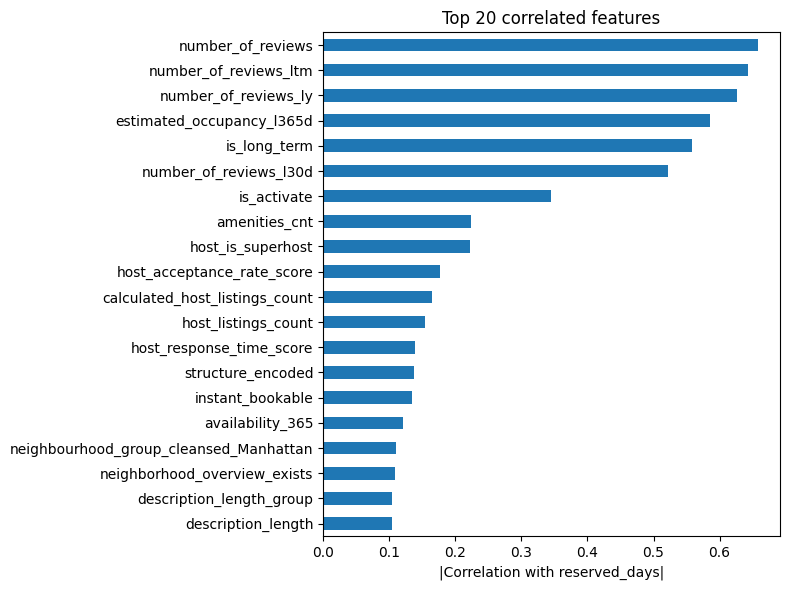

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype

# 1) reserved_days 는 타깃이므로 제외
targets = 'reserved_days'

# 2) jiwon_list 에서 실제로 df 에 있는 컬럼만, 그리고 숫자형만 골라내기
valid_feats = []
for col in jiwon_list:
    if col not in df.columns or col == targets:
        continue
    if is_numeric_dtype(df[col]):
        valid_feats.append(col)

# 3) 상관계수 계산
corr = df[valid_feats + [targets]].corr()[targets] \
           .drop(targets) \
           .abs() \
           .sort_values(ascending=False)

print("상관계수 구할 수 있는 피처들:", valid_feats)
print("reserved_days 와의 상관계수 (절대값 순):\n", corr.head(20))

# 4) 시각화 (예: 상위 20개)
plt.figure(figsize=(8,6))
corr.head(20).plot.barh()
plt.xlabel('|Correlation with reserved_days|')
plt.title('Top 20 correlated features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [85]:
# 위데이터 넣어서 구하기

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# 1) 데이터 불러오기 & 피처/타깃 설정
TARGET = "reserved_days"
features = [  # 앞서 선정한 피처 리스트
 'log_price',
 'instant_bookable',
 'availability_365',
 'calculated_host_listings_count',
 'is_long_term',
 'is_activate',
 'amenities_cnt',
 'accommodates',
 'bath_score_mul',
 'review_scores_rating',
 'name_length_group',
 'description_length_group',
 'neighborhood_overview_exists',
 'host_about_length_group',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_response_rate_score',
 'host_acceptance_rate_score',
 'host_location_ny',
 'host_location_boolean',
 'town_encoded',
 'structure_encoded',
 'transport_count','infrastructure_count','tourism_count',
 'host_verifications_count',
 'price_rating']
X = df[features].fillna(0)
y = df[TARGET]

# 2) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) 하이퍼파라미터 분포 설정
rf = RandomForestRegressor(random_state=42)
rf_params = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_params = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# 4) RandomizedSearchCV
rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

xgb_search = RandomizedSearchCV(
    xgb, xgb_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

print("✔ Best RF params:", rf_search.best_params_)
print("✔ Best XGB params:", xgb_search.best_params_)

# 5) 검증 성능 (튜닝 후)
def eval_model(model, X_t, y_t):
    y_pred = model.predict(X_t)
    return root_mean_squared_error(y_t, y_pred), mean_absolute_error(y_t, y_pred), r2_score(y_t, y_pred)

rf_rmse, rf_mae, rf_r2 = eval_model(best_rf, X_test, y_test)
xgb_rmse, xgb_mae, xgb_r2 = eval_model(best_xgb, X_test, y_test)
print(f"RF tuned  RMSE={rf_rmse:.2f}, MAE={rf_mae:.2f}, R2 Score={rf_r2:.2f}")
print(f"XGB tuned RMSE={xgb_rmse:.2f}, MAE={xgb_mae:.2f}, R2 Score={xgb_r2:.2f}")

# 6) Ensemble: Voting Regressor
voting = VotingRegressor([("rf", best_rf), ("xgb", best_xgb)])
voting.fit(X_train, y_train)
v_rmse, v_mae, v_r2 = eval_model(voting, X_test, y_test)
print(f"Voting   RMSE={v_rmse:.2f}, MAE={v_mae:.2f}, R2 Score={v_r2:.2f}")

# 7) Ensemble: Stacking Regressor
stack = StackingRegressor(
    estimators=[("rf", best_rf), ("xgb", best_xgb)],
    final_estimator=RidgeCV(),
    cv=3,
    n_jobs=-1
)
stack.fit(X_train, y_train)
s_rmse, s_mae, s_r2 = eval_model(stack, X_test, y_test)
print(f"Stacking RMSE={s_rmse:.2f}, MAE={s_mae:.2f}, R2 Score={s_r2:.2f}")

print(rf_r2, xgb_r2, v_r2, s_r2)


✔ Best RF params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
✔ Best XGB params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
RF tuned  RMSE=19.58, MAE=9.97, R2 Score=0.64
XGB tuned RMSE=19.65, MAE=10.36, R2 Score=0.63
Voting   RMSE=19.29, MAE=10.00, R2 Score=0.65
Stacking RMSE=19.29, MAE=10.00, R2 Score=0.65
0.6361913919940778 0.63364544155079 0.6468853021544758 0.6471008846989936


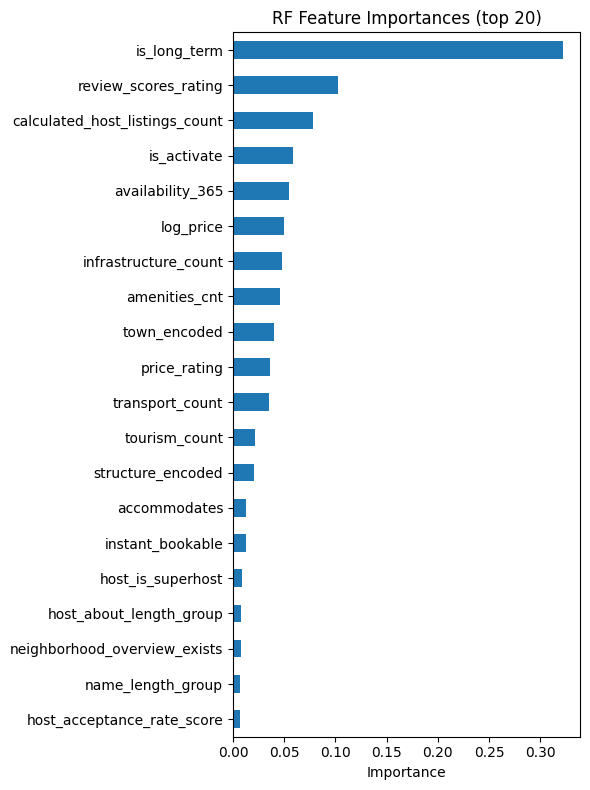

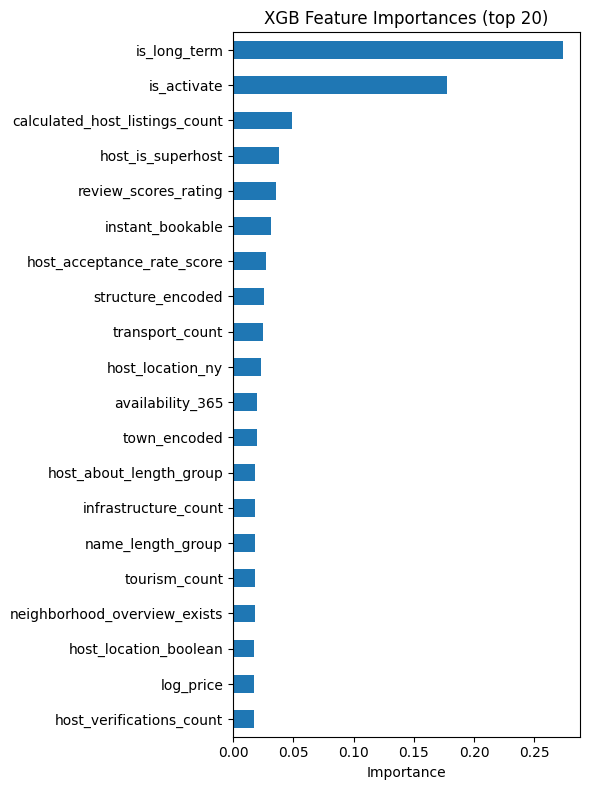

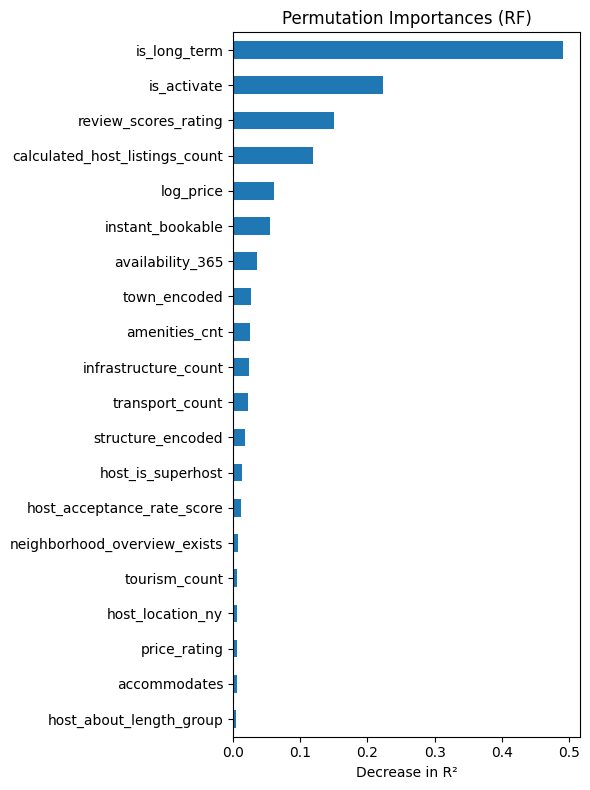


=== VIF (top 20) ===
                       feature         VIF
26                price_rating  387.247215
0                    log_price  344.491966
9         review_scores_rating  225.699399
16    host_response_rate_score   53.295472
15        host_has_profile_pic   38.568145
25    host_verifications_count   24.107210
17  host_acceptance_rate_score   20.390427
21           structure_encoded   17.838223
19       host_location_boolean   14.780292
11    description_length_group   10.418934
18            host_location_ny   10.318939
8               bath_score_mul    8.350943
6                amenities_cnt    7.357222
4                 is_long_term    7.254215
22             transport_count    6.556780
2             availability_365    5.794747
23        infrastructure_count    5.634853
7                 accommodates    5.241853
5                  is_activate    4.403113
24               tourism_count    4.314604


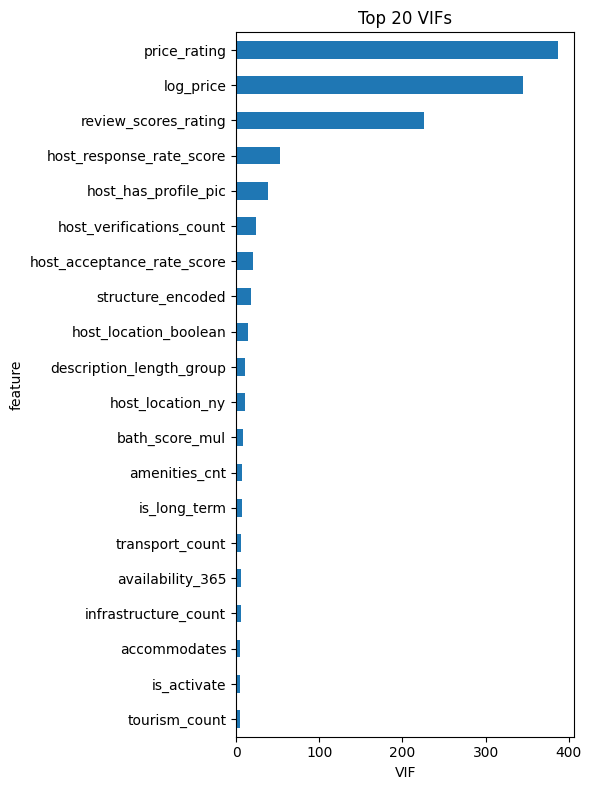

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance

# 1) (이미 학습된) best_rf, best_xgb 와 feature 리스트가 있다고 가정
# features = [...]  # 위에서 쓰신 features 리스트

# 2) RandomForest 피처 중요도 시각화
rf_importances = pd.Series(
    best_rf.feature_importances_, index=features
).sort_values(ascending=True)

plt.figure(figsize=(6,8))
rf_importances.tail(20).plot.barh(title="RF Feature Importances (top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 3) XGB 피처 중요도 시각화
xgb_importances = pd.Series(
    best_xgb.feature_importances_, index=features
).sort_values(ascending=True)

plt.figure(figsize=(6,8))
xgb_importances.tail(20).plot.barh(title="XGB Feature Importances (top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# ▶ 추가: permutation importance (model-agnostic, RF 예시)
perm_imp = permutation_importance(
    best_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
perm_ser = pd.Series(perm_imp.importances_mean, index=features).sort_values()
plt.figure(figsize=(6,8))
perm_ser.tail(20).plot.barh(title="Permutation Importances (RF)")
plt.xlabel("Decrease in R²")
plt.tight_layout()
plt.show()


# 4) VIF 계산용 DataFrame 준비
X_vif = X_train.copy().fillna(0)  # 학습용 X를 사용하거나 전체 X를 써도 무방
vif_df = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i)
            for i in range(X_vif.shape[1])]
})
vif_df = vif_df.sort_values("VIF", ascending=False)

print("\n=== VIF (top 20) ===")
print(vif_df.head(20))

# 시각화 (선택)
plt.figure(figsize=(6,8))
vif_df.head(20).set_index("feature")["VIF"].plot.barh(title="Top 20 VIFs")
plt.xlabel("VIF")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [83]:
df = df.copy()  # 원본 보존
df['price_rating'] = df['log_price'] * df['review_scores_rating']

In [87]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=1)
imp_df = pd.Series(perm.importances_mean, index=features).sort_values(ascending=False)
print("Top 10 by permutation:\n", imp_df.head(10))


Top 10 by permutation:
 is_long_term                      0.501169
is_activate                       0.220342
review_scores_rating              0.150498
calculated_host_listings_count    0.113766
log_price                         0.063184
instant_bookable                  0.057912
availability_365                  0.031413
town_encoded                      0.029184
amenities_cnt                     0.025294
transport_count                   0.024010
dtype: float64


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model   import LinearRegression

lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=15)  # 상위 15개만 남기기
rfe.fit(X_train, y_train)
selected = X_train.columns[rfe.support_]
print("RFE selected:", list(selected))
